# Baseline: Line/Curve-fitting or Linear Methods, Perhaps with Kernels

### Results from earlier tests and other notebooks

Only non-trivial results are recorded. The original baseline dataset is used as the default unless otherwise stated.

**No PCA, no polynomial features**

KNN Regressor (weights='distance', n_neighbors=16): f1-score \[0.50547 0.51170 0.40000 0.32195 \] average 0.43478

KNN Regressor (weights='distance', n_neighbors=40): f1-score \[0.61 0.59 0.48 0.41 \] average 0.52250 (unknown whether PCA was present)

SplineTransformer + SVR + Nystroem: f1-score \[0.49127 0.45027 0.28922 0.23324\] average 0.36600

MARS (degree 4, max terms 500): f1-score \[0.46684 0.41887 0.25532 0.12648\] average 0.31688

Average F1 score of TSNV Logit is **0.54243**, and is the best among all three baseline dataset variants.

Poly features, no PCA, Nystroem (poly, 3, 500): f1-score \[0.50722 0.48371 0.34934 0.18898\] average 0.38231

**Yes PCA, yes polynomial features**

Correct to 2 sig.fig.,

Logit (300 iters), PCA (450): f1-score \[0.59 0.56 0.39 0.30\] average 0.46

Logit 300, no PCA, PolynomialCountSketch(gamma=0.2, n_components=500): F1-score \[0.56 0.53 0.36 0.29 \] average 0.435

Logit 500-750, PCA 450, Nystroem(kernel='poly', degree=3, n_components=500): f1-score \[0.53162 0.52863 0.34551 0.19549\] average 0.40031 

MARS (degree 5, terms 600): f1-score \[0.48130 0.51295 0.31718 0.18927\] average 0.37518

In [1]:
# Import statements
# sklearn stuff are imported later
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read data

In [3]:
# read Dataset as Pandas DataFrame
print("================ Reading dataset ===============")
dataset = pd.read_pickle('../Dataset/baseline_dataset.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

================ Reading dataset ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45293 entries, 0 to 45292
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MM             45293 non-null  int64  
 1   DD             45293 non-null  int64  
 2   HH             45293 non-null  int64  
 3   LOW_IMPACT     45293 non-null  bool   
 4   MID_IMPACT     45293 non-null  bool   
 5   BIG_IMPACT     45293 non-null  bool   
 6   DIRECT_STRIKE  45293 non-null  bool   
 7   00LAT          45293 non-null  float32
 8   00LON          45293 non-null  float32
 9   00WIND         45293 non-null  int32  
 10  06LAT          45293 non-null  float32
 11  06LON          45293 non-null  float32
 12  06WIND         45293 non-null  int32  
 13  12LAT          45293 non-null  float32
 14  12LON          45293 non-null  float32
 15  12WIND         45293 non-null  int32  
 16  18LAT          45293 non-null  float32
 17  1

In [4]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

# Constants
TRAIN_RATIO = 0.9

In [5]:
# test-dev-train split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,3:7]).astype(int)
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36686; Dev set size: 4077; Testing set size: 4530


### Tools

In [6]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/baseline_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)
    
    # to load a model: model = joblib.load(filename)

In [7]:
# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [8]:
# new utility functions
from scipy.special import expit

def regression_predict(regr, datasetX, method='sigmoid'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='sigmoid'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='sigmoid'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [9]:
# imports
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem, PolynomialCountSketch
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import classification_report

## No PCA, No Polynomial Features

Please see the above TLDR and the old notebook for models that use PCA and polynomial features to a large extent.

### Linear Classifiers

Training accuracy: 0.8817805157
Accuracy of classifier on dev set: 0.8898700025
Best Threshold=0.11878, F-Score=0.33198
Best Threshold=0.09398, F-Score=0.31151
Best Threshold=0.04617, F-Score=0.12632
Best Threshold=0.02973, F-Score=0.09836


/tmp/.u3556490/ipykernel_20138/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


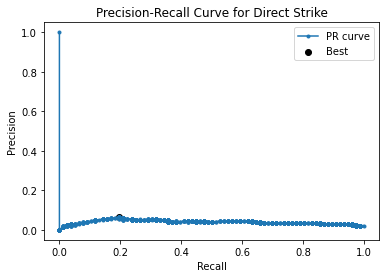

In [9]:
basic_clf_1 = OneVsRestClassifier(LogisticRegression(
    max_iter=3000,
    C=0.5,
    verbose=0   
), n_jobs=-1)

basic_clf_1 = basic_clf_1.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_1.predict(train_X))))

# test model on dev set
preds = basic_clf_1.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

best_thresholds, best_f1_scores = optimize_thresholds(basic_clf_1, dev_X, dev_Y)

In [9]:
from sklearn.svm import LinearSVC

basic_clf_2 = OneVsRestClassifier(LinearSVC(dual=False, max_iter=3000), n_jobs=-1)

basic_clf_2 = basic_clf_2.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_2.predict(train_X))))

# test model on dev set
preds = basic_clf_2.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

best_thresholds, best_f1_scores = optimize_thresholds(basic_clf_2, dev_X, dev_Y)

Training accuracy: 0.8837158589
Accuracy of classifier on dev set: 0.8844738779


AttributeError: This 'OneVsRestClassifier' has no attribute 'predict_proba'

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training accuracy: 0.1993403478
Accuracy of classifier on dev set: 0.2016188374


/tmp/.u3556490/ipykernel_23916/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_23916/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_23916/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_23916/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.09016, F-Score=0.34244
Best Threshold=0.08049, F-Score=0.25146
Best Threshold=0.02654, F-Score=0.05439
Best Threshold=0.02726, F-Score=0.12935


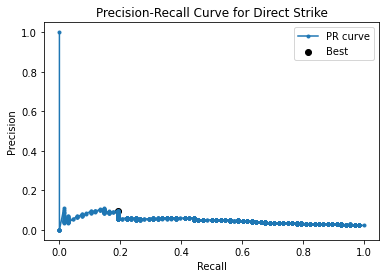

In [15]:
from sklearn.svm import NuSVC

basic_clf_3 = OneVsRestClassifier(NuSVC(nu=0.02, kernel='poly', probability=True, max_iter=3000), n_jobs=-1)

basic_clf_3 = basic_clf_3.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_3.predict(train_X))))

# test model on dev set
preds = basic_clf_3.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

best_thresholds, best_f1_scores = optimize_thresholds(basic_clf_3, dev_X, dev_Y)

### Regressors

Best Threshold=0.53053, F-Score=0.33646
Best Threshold=0.52751, F-Score=0.32134
Best Threshold=0.51140, F-Score=0.15802
Best Threshold=0.50943, F-Score=0.11628


/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


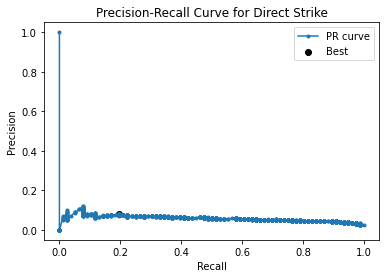

In [11]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

linear_regr = MultiOutputRegressor(LinearRegression(), n_jobs=-1)
linear_regr = linear_regr.fit(train_X, train_Y)

best_thresholds, best_f1_scores = regressor_find_thresholds(linear_regr, dev_X, dev_Y, 'sigmoid')

Best Threshold=0.53229, F-Score=0.33356
Best Threshold=0.52744, F-Score=0.32107
Best Threshold=0.51123, F-Score=0.15951
Best Threshold=0.50862, F-Score=0.12183


/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


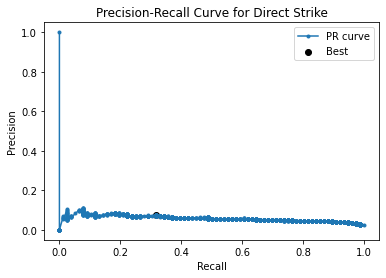

In [12]:
from sklearn.svm import LinearSVR

svr_regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

svr_regr = svr_regr.fit(train_X, train_Y)

best_thresholds, best_f1_scores = regressor_find_thresholds(svr_regr, dev_X, dev_Y, 'sigmoid')

/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.57781, F-Score=0.50728
Best Threshold=0.57175, F-Score=0.51387
Best Threshold=0.54820, F-Score=0.40559
Best Threshold=0.53425, F-Score=0.33010


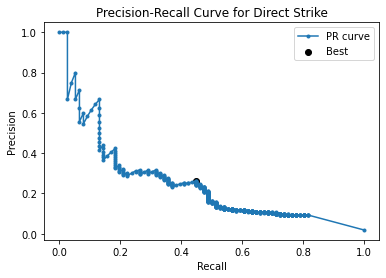

In [17]:
from sklearn.neighbors import KNeighborsRegressor

knr_regr = MultiOutputRegressor(KNeighborsRegressor(weights='distance', n_neighbors=16), n_jobs=-1)

knr_regr = knr_regr.fit(train_X, train_Y)

best_thresholds, best_f1_scores = regressor_find_thresholds(knr_regr, dev_X, dev_Y, 'sigmoid')

In [19]:
print("Finally, something remotely useful!")
preds = regression_label(knr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Finally, something remotely useful!
              precision    recall  f1-score   support

           0    0.44068   0.59259   0.50547       351
           1    0.42787   0.63636   0.51170       275
           2    0.33929   0.48718   0.40000       117
           3    0.25581   0.43421   0.32195        76

   micro avg    0.40153   0.57753   0.47371       819
   macro avg    0.36591   0.53759   0.43478       819
weighted avg    0.40474   0.57753   0.47546       819
 samples avg    0.05821   0.06392   0.05683       819



Pipeline(steps=[('splinetransformer', SplineTransformer(include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('nystroem', Nystroem(degree=3, kernel='poly')),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.5, dual=False,
                                                          loss='squared_epsilon_insensitive'),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] . (step 1 of 4) Processing splinetransformer, total=   0.2s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing nystroem, total=   0.4s
[Pipeline]  (step 4 of 4) Processing multioutputregressor, total=   4.7s
Best Threshold=0.56293, F-Score=0.49291
Best Threshold=0.54623, F-Score=0.45197
Best Threshold=0.52741, F-Score=0.29340
Best Threshold=0.51828, F-Score=0.23837


/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


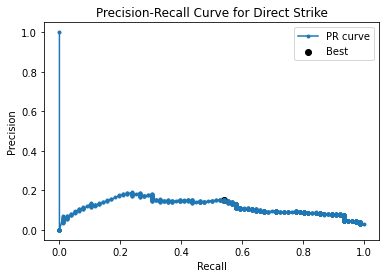

In [23]:
from sklearn.preprocessing import SplineTransformer

svr_regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

pipe = make_pipeline(
    SplineTransformer(include_bias=False),
    StandardScaler(),
    # PolynomialCountSketch(degree=3, n_components=300),
    Nystroem(kernel='poly', degree=3),
    svr_regr, verbose=True
)
print(pipe)

poly_svr_regr = pipe.fit(train_X, train_Y)
best_thresholds, best_f1_scores = regressor_find_thresholds(poly_svr_regr, dev_X, dev_Y, 'sigmoid')

In [24]:
preds = regression_label(poly_svr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.39823   0.64103   0.49127       351
           1    0.32188   0.74909   0.45027       275
           2    0.20275   0.50427   0.28922       117
           3    0.14981   0.52632   0.23324        76

   micro avg    0.30062   0.64713   0.41053       819
   macro avg    0.26817   0.60518   0.36600       819
weighted avg    0.32161   0.64713   0.42469       819
 samples avg    0.05310   0.07074   0.05548       819



### MARS

Best Threshold=0.54843, F-Score=0.46816
Best Threshold=0.53944, F-Score=0.42036
Best Threshold=0.53263, F-Score=0.26148
Best Threshold=0.51024, F-Score=0.12895


/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_20138/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


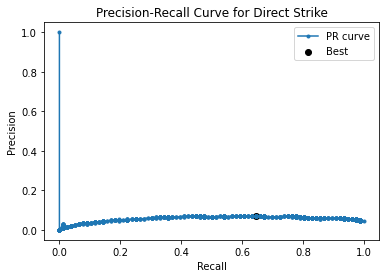

In [25]:
from pyearth import Earth

earth_regr = MultiOutputRegressor(Earth(max_degree=4, max_terms=500, use_fast=True), n_jobs=-1)
earth_regr = earth_regr.fit(train_X, train_Y)
best_thresholds, best_f1_scores = regressor_find_thresholds(earth_regr, dev_X, dev_Y, 'sigmoid')

In [26]:
preds = regression_label(earth_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.33457   0.77208   0.46684       351
           1    0.28280   0.80727   0.41887       275
           2    0.21818   0.30769   0.25532       117
           3    0.07028   0.63158   0.12648        76

   micro avg    0.23619   0.70452   0.35377       819
   macro avg    0.22646   0.62966   0.31688       819
weighted avg    0.27603   0.70452   0.38893       819
 samples avg    0.05850   0.07939   0.06165       819



### Generalized Linear Model

Doesn't work.

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=TweedieRegressor(link='log',
                                                                 max_iter=200,
                                                                 power=1),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 2) Processing multioutputregressor, total=   2.1s
Best Threshold=0.52371, F-Score=0.40076
Best Threshold=0.51889, F-Score=0.38238
Best Threshold=0.50715, F-Score=0.16427
Best Threshold=0.50488, F-Score=0.10204


/tmp/ipykernel_27942/339355959.py:29: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/ipykernel_27942/339355959.py:29: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/ipykernel_27942/339355959.py:29: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/ipykernel_27942/339355959.py:29: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


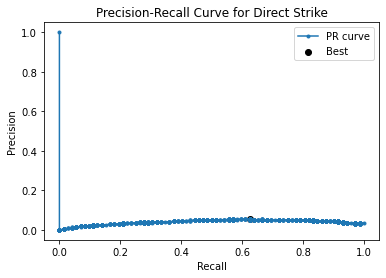

In [15]:
from sklearn.linear_model import TweedieRegressor

glm_regr = MultiOutputRegressor(TweedieRegressor(power=1, max_iter=200, link='log'), n_jobs=-1)

pipe = make_pipeline(
    StandardScaler(),
    glm_regr, verbose=True
)
print(pipe)

glm_regr = pipe.fit(train_X, train_Y)
best_thresholds, best_f1_scores = regressor_find_thresholds(glm_regr, dev_X, dev_Y, 'sigmoid')

## Generalized Additive Model

main observations:
- gamma, inverse gamma and error distributions are unsuitable  
- select top 15 poly features from a well-fitted tree (overfit decision tree/extra trees/gradient boosting tree) => not enough, takes ages too  
- put the original features through 400 splines each, then linear GAM can only get pseudo R squared <= 0.35 and average f1 <= 0.45  
- logistic GAM takes longer to fit, and cannot detect positives (just like a basic logit with insufficient iters)  
- from p-values: date and hour are indeed quite irrelevant, reasoning based on the rest of the time sequence (12 hours onwards) is also not very useful

In [9]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36686 entries, 2120 to 33876
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MM      36686 non-null  int64  
 1   DD      36686 non-null  int64  
 2   HH      36686 non-null  int64  
 3   00LAT   36686 non-null  float32
 4   00LON   36686 non-null  float32
 5   00WIND  36686 non-null  int32  
 6   06LAT   36686 non-null  float32
 7   06LON   36686 non-null  float32
 8   06WIND  36686 non-null  int32  
 9   12LAT   36686 non-null  float32
 10  12LON   36686 non-null  float32
 11  12WIND  36686 non-null  int32  
 12  18LAT   36686 non-null  float32
 13  18LON   36686 non-null  float32
 14  18WIND  36686 non-null  int32  
 15  24LAT   36686 non-null  float32
 16  24LON   36686 non-null  float32
 17  24WIND  36686 non-null  int32  
dtypes: float32(10), int32(5), int64(3)
memory usage: 3.2 MB


##### Select features from poly first

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
transformed_X = poly.fit_transform(train_X)
clf = GradientBoostingClassifier().fit(transformed_X, train_Y[:,0])
sfm = SelectFromModel(estimator=clf, max_features=15, prefit=True)
print(clf.score(transformed_X, train_Y[:,0]))

mask = sfm.get_support()
names = poly.get_feature_names_out()
scores = sfm.estimator.feature_importances_

importance = np.stack([names[mask], scores[mask]], axis=1)
print(importance[np.argsort(importance[:,1])])

0.9455650656926348
[['00LAT 00WIND 12LAT' 0.00927660629221202]
 ['MM 06LON' 0.009998932164633743]
 ['00LON 06LON' 0.010339518608710428]
 ['00LAT 18LON 24LON' 0.012378625143979992]
 ['00LAT' 0.01695556653995115]
 ['24LON' 0.019573646425922936]
 ['00LAT 06LON' 0.02175388599886791]
 ['00LAT 00LON 12LON' 0.027468050876649837]
 ['MM 00LAT 12LAT' 0.028374047908132218]
 ['MM 00LAT 06LAT' 0.03319134345750633]
 ['MM' 0.051307878842339755]
 ['00LAT 00LON 24LON' 0.05701864980533669]
 ['00LAT 00LON 06LON' 0.06373036752679734]
 ['MM 00LON' 0.07013984224094547]
 ['00LON' 0.3842840747566399]]


In [10]:
importance = np.flip(importance[np.argsort(importance[:,1])], axis=0)

names_in = poly.feature_names_in_
names_out = poly.get_feature_names_out()

for row in importance:
    tokens = row[0].split()
    if len(tokens) == 1:        
        pos = int(np.where(names_in == tokens[0])[0])
        print("s({0})+".format(pos), end="")
    else:
        print("te(", end="")
        for i in range(len(tokens)):
            pos = int(np.where(names_in == tokens[i])[0])
            print(pos, end="")
            if not (i+1 == len(tokens)):
                print(",",end="")
        print(")+",end="")
        
print()

s(4)+te(0,4)+te(3,4,7)+te(3,4,16)+s(0)+te(0,3,6)+te(0,3,9)+te(3,4,10)+te(3,7)+s(16)+s(3)+te(3,13,16)+te(4,7)+te(0,7)+te(3,5,9)+


In [11]:
from pygam import LinearGAM, LogisticGAM, f, s, l, te

gam0 = LinearGAM(
    s(4)+te(0,4)+te(3,4,7)+te(3,4,16)+s(0)+te(0,3,6)+te(0,3,9)+te(3,4,10)+te(3,7)+s(16)+s(3)+te(3,13,16)+te(4,7)+te(0,7)+te(3,5,9),
    max_iter=500, verbose=True
).fit(train_X, train_Y[:,3])

gam0.summary()

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/pygam.py:591: RuntimeWarning: over

OptimizationError: PIRLS optimization has diverged.
Try increasing regularization, or specifying an initial value for self.coef_

In [14]:
preds = expit(gam0.predict(dev_X))

precision, recall, thresholds = precision_recall_curve(dev_Y[:,0], preds)
# find best threshold
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

temp = np.array(preds > thresholds[ix]).astype(int)

print(classification_report(dev_Y[:,0], temp, zero_division=0))

Best Threshold=0.73106, F-Score=0.55342
              precision    recall  f1-score   support

           0       0.91      1.00      0.96      3729
           1       0.00      0.00      0.00       348

    accuracy                           0.91      4077
   macro avg       0.46      0.50      0.48      4077
weighted avg       0.84      0.91      0.87      4077



##### Target by target, original features

default settings for all, all features, linear GAM: f1-score \[0.59411 0.52308 0.37885 0.30392\] average 0.44999  
100-300 splines each (except time terms), all features, linear GAM: f1-score \[0.63234 0.59212 0.41667 0.30000\] average 0.48528  
factor terms for all, omit hour and day, linearGAM: f1-score \[0.55394 0.52761 0.31579 0.31579\] average 0.42828  
400 splines each, omit hour and day, linearGAM: f1-score \[0.56840 0.52857 0.38431 0.41558\] average 0.47422

In [38]:
from pygam import LinearGAM, s, l, f

gam0 = LinearGAM(
    s(0)+
    s(3, n_splines=400)+s(4, n_splines=400)+s(5, n_splines=400)+
    s(6, n_splines=400)+s(7, n_splines=400)+s(8, n_splines=400)+
    s(9, n_splines=400)+s(10, n_splines=400)+s(11, n_splines=400)+
    s(12, n_splines=400)+s(13, n_splines=400)+s(14, n_splines=400)+
    s(15, n_splines=400)+s(16, n_splines=400)+s(17, n_splines=400),
    max_iter=500, verbose=True
).fit(train_X, train_Y[:,0])

gam0.summary()

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1869.7112
Link Function:                     IdentityLink Log Likelihood:                               -230211.2742
Number of Samples:                        36686 AIC:                                           464163.9707
                                                AICc:                                          464365.1198
                                                GCV:                                                0.0636
                                                Scale:                                              0.0578
                                                Pseudo R-Squared:                                   0.3221
Feature Function                  Lam

/tmp/.u3556490/ipykernel_16243/1157289223.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam0.summary()


<Figure size 432x288 with 0 Axes>

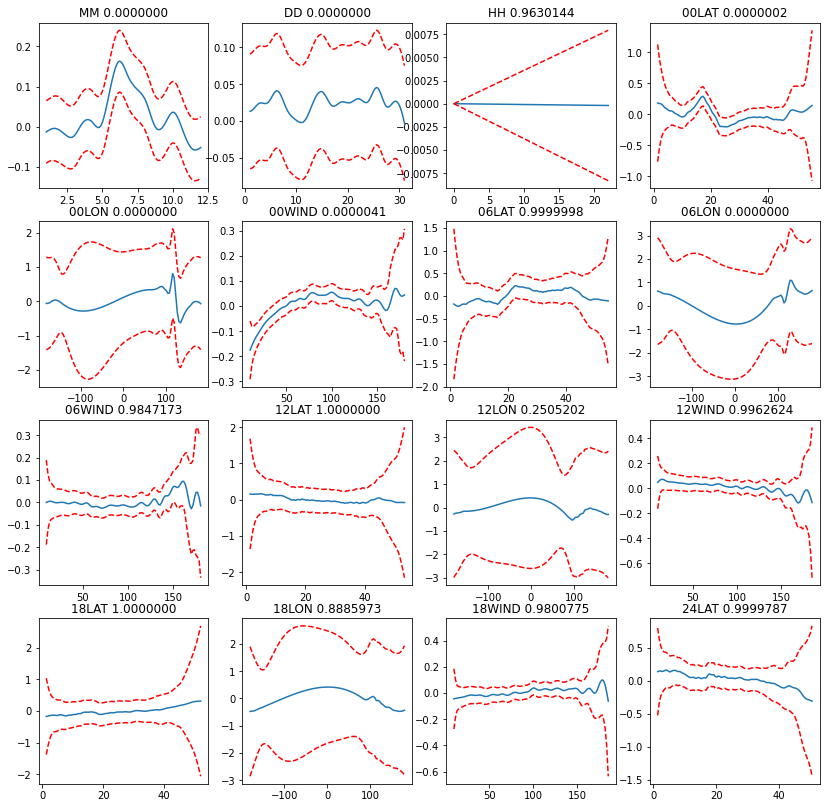

In [24]:
plt.figure()
fig, axs = plt.subplots(4,4,figsize=(14,14))

for i in range(4):
    for j in range(4):
        XX = gam0.generate_X_grid(term=i*4+j)
        axs[i,j].plot(XX[:, i*4+j], gam0.partial_dependence(term=i*4+j, X=XX))
        axs[i,j].plot(XX[:, i*4+j], gam0.partial_dependence(term=i*4+j, X=XX, width=.95)[1], c='r', ls='--')
        axs[i,j].set_title("{0} {1:.7f}".format(train_X.columns[i*4+j], gam0.statistics_['p_values'][i*4+j]))

In [11]:
gam1 = LinearGAM(
    s(0)+ 
    s(3, n_splines=400)+s(4, n_splines=400)+s(5, n_splines=400)+
    s(6, n_splines=400)+s(7, n_splines=400)+s(8, n_splines=400)+
    s(9, n_splines=400)+s(10, n_splines=400)+s(11, n_splines=400)+
    s(12, n_splines=400)+s(13, n_splines=400)+s(14, n_splines=400)+
    s(15, n_splines=400)+s(16, n_splines=400)+s(17, n_splines=400),
    '''f(0)+ 
    f(3)+f(4)+f(5)+
    f(6)+f(7)+f(8)+
    f(9)+f(10)+f(11)+
    f(12)+f(13)+f(14)+
    f(15)+f(16)+f(17),'''
    max_iter=1000, verbose=True
).fit(train_X, train_Y[:,1])

gam1.summary()

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2792.1105
Link Function:                     IdentityLink Log Likelihood:                               -272274.6977
Number of Samples:                        36686 AIC:                                           550135.6164
                                                AICc:                                          550596.1549
                                                GCV:                                                0.0561
                                                Scale:                                              0.0485
                                                Pseudo R-Squared:                                   0.2991
Feature Function                  Lam

/tmp/.u3556490/ipykernel_7519/592392113.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam1.summary()


In [13]:
gam2 = LinearGAM(
    s(0)+ 
    s(3, n_splines=400)+s(4, n_splines=400)+s(5, n_splines=400)+
    s(6, n_splines=400)+s(7, n_splines=400)+s(8, n_splines=400)+
    s(9, n_splines=400)+s(10, n_splines=400)+s(11, n_splines=400)+
    s(12, n_splines=400)+s(13, n_splines=400)+s(14, n_splines=400)+
    s(15, n_splines=400)+s(16, n_splines=400)+s(17, n_splines=400),
    max_iter=500, verbose=True
).fit(train_X, train_Y[:,2])

gam2.summary()

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2792.1105
Link Function:                     IdentityLink Log Likelihood:                               -635481.6333
Number of Samples:                        36686 AIC:                                          1276549.4877
                                                AICc:                                         1277010.0262
                                                GCV:                                                0.0265
                                                Scale:                                              0.0229
                                                Pseudo R-Squared:                                   0.1751
Feature Function                  Lam

/tmp/.u3556490/ipykernel_7519/2232370159.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam2.summary()


In [14]:
gam3 = LinearGAM(
    s(0)+ 
    s(3, n_splines=400)+s(4, n_splines=400)+s(5, n_splines=400)+
    s(6, n_splines=400)+s(7, n_splines=400)+s(8, n_splines=400)+
    s(9, n_splines=400)+s(10, n_splines=400)+s(11, n_splines=400)+
    s(12, n_splines=400)+s(13, n_splines=400)+s(14, n_splines=400)+
    s(15, n_splines=400)+s(16, n_splines=400)+s(17, n_splines=400),
    max_iter=500, verbose=True
).fit(train_X, train_Y[:,3])

gam3.summary()

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2792.1105
Link Function:                     IdentityLink Log Likelihood:                               -876615.3081
Number of Samples:                        36686 AIC:                                          1758816.8373
                                                AICc:                                         1759277.3757
                                                GCV:                                                0.0198
                                                Scale:                                              0.0171
                                                Pseudo R-Squared:                                   0.1425
Feature Function                  Lam

/tmp/.u3556490/ipykernel_7519/1948665596.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam3.summary()


##### Testing and saving

In [15]:
raw_preds = np.stack([gam0.predict(dev_X), gam1.predict(dev_X), gam2.predict(dev_X), gam3.predict(dev_X)], axis=1)
print(raw_preds.shape)

(4077, 4)


Best Threshold=0.29543, F-Score=0.59591
Best Threshold=0.25514, F-Score=0.52560
Best Threshold=0.13048, F-Score=0.38596
Best Threshold=0.08974, F-Score=0.31220


/tmp/.u3556490/ipykernel_24861/3007120922.py:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_24861/3007120922.py:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_24861/3007120922.py:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


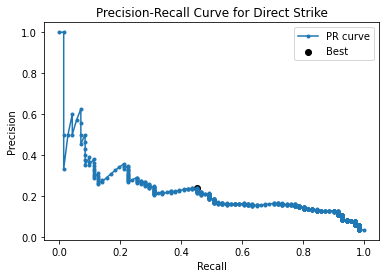

In [11]:
best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

In [12]:
preds = []
# iterate each predicted probability and compare against threshold
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

In [13]:
print(classification_report(dev_Y, preds, digits=5, zero_division=0))

              precision    recall  f1-score   support

           0    0.57002   0.62032   0.59411       374
           1    0.47962   0.57519   0.52308       266
           2    0.31852   0.46739   0.37885        92
           3    0.23308   0.43662   0.30392        71

   micro avg    0.46177   0.57161   0.51085       803
   macro avg    0.40031   0.52488   0.44999       803
weighted avg    0.48147   0.57161   0.52026       803
 samples avg    0.05515   0.06416   0.05508       803



In [19]:
import pickle as pk

model = [gam0, gam1, gam2, gam3]

pk.dump(model, open("./models/baseline_model_gamF_{}.pkl".format(str(datetime.now().strftime("%Y-%m-%d %H-%M"))), 'wb'))